In [147]:
from tinkoff.invest import Client
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from plotly.offline import iplot, init_notebook_mode

from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [155]:
!pip install cufflinks

  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68729 sha256=b6131b90e13dc182f09733bdd246cb2252c74f461afb1c8ffa42591a8474ceba
  Stored in directory: c:\users\danila\appdata\local\pip\cache\wheels\6b\76\62\6da97734911ffcbdd559fd1a3f28526321f0ae699182a23866
Successfully built cufflinks


In [85]:
def money(v):
    return v.units + v.nano / 1e9

In [86]:
#Информация о инструменте и лотность
def info_instrument(instrument):
    name = []
    figi = []
    ticker = []
    lot = []
    currency = []
    country = []
    sector = []
    nominal = []
    
    lots = {}
    
    for i in instrument:
        lots[i.figi] = i.lot
        figi.append(i.figi)
        name.append(i.name)
        ticker.append(i.ticker)
        lot.append(i.lot)
        currency.append(i.currency)
        country.append(i.country_of_risk_name)
        try:
            nominal.append(money(i.nominal))
        except AttributeError:
            nominal.append(None)
        try:
            sector.append(i.sector)
        except AttributeError:
            sector.append(None)
    
    list_info = [name, figi, ticker, lot, currency, country, sector, nominal]
    list_info_name = ['name', 'figi', 'ticker', 'lot', 'currency', 'country', 'sector', 'nominal']
    dict_info = {}
    
    for i in range(8):
        dict_info[list_info_name[i]] = list_info[i]
            
    return dict_info, lots

**Файл с токеном**

In [87]:
token = open('C:/Users/Danila/Desktop/jupyter/my/Тинькофф инвестиции/Проект 1.txt', 'r').read()

# Данные

In [88]:
accounts_id = []
accounts_name = []
accounts_opened = []

with Client(token) as client:
    
    #Информация о брокерских счетах
    accounts = client.users.get_accounts()
    for account in accounts.accounts:
        accounts_id.append(account.id)
        accounts_name.append(account.name)
        accounts_opened.append(account.opened_date.date())
        
    #Информация о всех инструментах
    info_shares = info_instrument(client.instruments.shares().instruments)[0]
    info_bonds = info_instrument(client.instruments.bonds().instruments)[0]
    info_etfs = info_instrument(client.instruments.etfs().instruments)[0]
    info_currencies = info_instrument(client.instruments.currencies().instruments)[0]
    
    #Лотность инструмента
    lots_info_shares = info_instrument(client.instruments.shares().instruments)[1]
    lots_info_bonds = info_instrument(client.instruments.bonds().instruments)[1]
    lots_info_etfs = info_instrument(client.instruments.etfs().instruments)[1]
    lots_info_currencies = info_instrument(client.instruments.currencies().instruments)[1]

In [89]:
#Лотность всех инструментов    
all_lots_info = {**lots_info_shares, **lots_info_bonds, **lots_info_etfs, **lots_info_currencies}

#Таблицы с информацией о инстурментах
df_shares_info = pd.DataFrame(info_shares)
df_bonds_info = pd.DataFrame(info_bonds)
df_etfs_info = pd.DataFrame(info_etfs)
df_currencies_info = pd.DataFrame(info_currencies)

#Таблица с информацией о счетах
accounts = pd.DataFrame({'account_id': accounts_id,
                         'account_name': accounts_name,
                         'account_opened': accounts_opened})

In [90]:
number_account = 0

account_id = accounts.iloc[number_account][0]
start_date = datetime.datetime(accounts.iloc[number_account][2].year,
                               accounts.iloc[number_account][2].month,
                               accounts.iloc[number_account][2].day)

In [91]:
figi_buy = []
date_buy = []
price_buy = []
type_buy = []

figi_sold = []
date_sold = []
price_sold = []

figi_commission = []
commission = []

with Client(token) as client:
    r = client.operations.get_operations(account_id=account_id,
                                         from_=start_date,
                                         to=datetime.datetime.now()
                                        )
    for operation in r.operations:
        if operation.state == 1:
            if operation.type == 'Покупка ценных бумаг':
                if operation.figi not in ['BBG00VHGV1J0','', 'BBG00Y4RPMM1']:
                    if int(operation.quantity) % int(all_lots_info[operation.figi]) == 0:
                        for i in range(int(operation.quantity / all_lots_info[operation.figi])):
                            figi_buy.append(operation.figi)
                            date_buy.append(operation.date)
                            price_buy.append(money(operation.price) * all_lots_info[operation.figi])
                            type_buy.append(operation.instrument_type)
                    else:
                        for i in range(int(operation.quantity)):
                            figi_buy.append(operation.figi)
                            date_buy.append(operation.date)
                            price_buy.append(money(operation.price))
                            type_buy.append(operation.instrument_type)
                        
                        
            elif operation.type == 'Продажа ценных бумаг':
                if operation.figi not in ['BBG00VHGV1J0','', 'BBG00Y4RPMM1']:
                    if int(operation.quantity) % int(all_lots_info[operation.figi]) == 0:
                        for i in range(int(operation.quantity / all_lots_info[operation.figi])):
                            figi_sold.append(operation.figi)
                            date_sold.append(operation.date)
                            price_sold.append(money(operation.price) * all_lots_info[operation.figi])
                    else:
                        for i in range(int(operation.quantity)):
                            figi_sold.append(operation.figi)
                            date_sold.append(operation.date)
                            price_sold.append(money(operation.price))
                        
            if operation.type == 'Удержание комиссии за операцию' :
                figi_commission.append(operation.figi)
                commission.append(money(operation.payment))

In [92]:
df_comission = pd.DataFrame({
                             'figi_commission': figi_commission,
                             'commission' : commission
                            })
df_comission = df_comission.groupby('figi_commission', as_index=False).agg({'commission': 'sum'})
df_comission

,figi_commission,commission
0,,-0.63
1,BBG000B9XRY4,-0.70
2,BBG000B9ZLB0,-0.09
3,BBG000BBJQV0,-0.09
4,BBG000BBK4B9,-0.06
...,...,...
80,BBG012F7Y8K5,-5.21
81,BBG0320C1036,-2.05
82,TCS00A102DK3,-4.85
83,TCS00A103117,-29.99


In [93]:
df_buy = pd.DataFrame({
                       'date_buy' : date_buy,
                       'figi': figi_buy,
                       'price_buy': price_buy,
                       'type': type_buy 
                        })

df_buy = df_buy.sort_values(['figi', 'date_buy']).reset_index(drop=True)

In [94]:
df_sold = pd.DataFrame({
                       'date_sold' : date_sold,
                       'figi': figi_sold,
                       'price_sold': price_sold
                        })

df_sold = df_sold.sort_values(['figi', 'date_sold']).reset_index(drop=True)

In [95]:
df_buy['c'] = df_buy.groupby(['figi']).cumcount()+1
df_sold['c'] = df_sold.groupby(['figi']).cumcount()+1

In [96]:
df_buy_sold = df_buy.merge(df_sold,
                           how='left',
                           on=['figi', 'c'])
df_buy_sold

,date_buy,figi,price_buy,type,c,date_sold,price_sold
0,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,etf,1,2021-05-07 07:41:28.205000+00:00,5.968012
1,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,etf,2,2021-05-07 07:41:28.205000+00:00,5.968012
2,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,etf,3,2021-05-07 07:41:28.205000+00:00,5.968012
3,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,etf,4,2021-05-07 07:41:28.205000+00:00,5.968012
4,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,etf,5,2021-05-07 07:41:28.205000+00:00,5.968012
...,...,...,...,...,...,...,...
5874,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000,bond,6,NaT,NaN
5875,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000,bond,7,NaT,NaN
5876,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000,bond,8,NaT,NaN
5877,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000,bond,9,NaT,NaN


In [137]:
usd_mean = df_buy_sold[df_buy_sold['figi'] == 'BBG0013HGFT4']['price_buy'].mean()
eur_mean = df_buy_sold[df_buy_sold['figi'] == 'BBG0013HJJ31']['price_buy'].mean()

In [104]:
figi_dividend = []
last_day_buy = []
dividend_net = []

with Client(token) as client:
    for figis_for_divident_info in list(df_buy_sold[df_buy_sold['type'] == 'share']['figi'].unique()):
        dividends_info = client.instruments.get_dividends(figi=figis_for_divident_info,
                                                          from_=start_date,
                                                          to=datetime.datetime.now())
        
        for day_dividend_info in dividends_info.dividends:
            figi_dividend.append(figis_for_divident_info)
            last_day_buy.append(day_dividend_info.last_buy_date)
            dividend_net.append(money(day_dividend_info.dividend_net) * all_lots_info[figis_for_divident_info])

In [105]:
df_dividend = pd.DataFrame({'figi': figi_dividend,
                            'last_day_buy': last_day_buy,
                            'dividend_net': dividend_net})
df_dividend

,figi,last_day_buy,dividend_net
0,BBG000B9XRY4,2022-02-03 00:00:00+00:00,0.2200
1,BBG000B9XRY4,2021-11-04 00:00:00+00:00,0.2200
2,BBG000B9XRY4,2021-08-05 00:00:00+00:00,0.2200
3,BBG000B9XRY4,2021-05-06 00:00:00+00:00,0.2200
4,BBG000B9XRY4,2021-02-04 00:00:00+00:00,0.2050
...,...,...,...
74,BBG00HFWVGN0,2021-07-21 00:00:00+00:00,0.0680
75,BBG00HFWVGN0,2021-03-10 00:00:00+00:00,0.1350
76,BBG00KHGQ0H4,2022-01-20 00:00:00+00:00,0.7140
77,BBG00KHGQ0H4,2021-06-07 00:00:00+00:00,0.4675


# Закрытые сделки

## Акции

In [132]:
df_closed_shares = df_buy_sold[(df_buy_sold['type'] == 'share') &
                               (~df_buy_sold['price_sold'].isna())]

In [144]:
df_closed_shares_gr = df_closed_shares.groupby('figi', as_index=False).agg({'price_buy': 'sum',
                                                                            'price_sold': 'sum'})
df_closed_shares_gr = df_closed_shares_gr.merge(df_shares_info,
                                                how='inner',
                                                on='figi')
df_closed_shares_gr['profit'] = df_closed_shares_gr['price_sold'] - df_closed_shares_gr['price_buy']
df_closed_shares_gr['profit_rub'] = np.where(df_closed_shares_gr['currency'] == 'usd', 
                                             df_closed_shares_gr['profit'] * usd_mean,
                                             df_closed_shares_gr['profit'])
df_closed_shares_gr['profit_rub'] = np.where(df_closed_shares_gr['currency'] == 'eur', 
                                             df_closed_shares_gr['profit_rub'] * eur_mean,
                                             df_closed_shares_gr['profit_rub'])
df_closed_shares_gr['profit_perc'] = (df_closed_shares_gr['price_sold'] / df_closed_shares_gr['price_buy'] - 1) * 100
df_closed_shares_gr = df_closed_shares_gr.iloc[:,[3,4,7,8,10,11,12]]
df_closed_shares_gr

,name,ticker,country,sector,profit,profit_rub,profit_perc
0,Apple,AAPL,Соединенные Штаты Америки,it,53.850000,4088.054400,6.410333
1,Compugen,CGEN,Государство Израиль,health_care,0.470000,35.680326,3.094141
2,China Life Insurance,LFC,Китайская Народная Республика,financial,0.110000,8.350715,1.078431
3,AMD,AMD,Соединенные Штаты Америки,it,6.650000,504.838658,1.921632
4,Deutsche Lufthansa AG,LHA@DE,Федеративная Республика Германия,industrials,0.270000,21.262071,4.728546
5,Bank of America Corp,BAC,Соединенные Штаты Америки,financial,-2.820000,-214.081957,-6.584170
6,Korea Electric Power,KEP,Республика Корея,utilities,0.700000,53.140911,6.392694
7,Carnival,CCL,Соединенные Штаты Америки,consumer,15.050002,1142.529747,4.773838
8,Transocean,RIG,Соединенные Штаты Америки,energy,2.360000,179.160787,5.625745
9,Cassava Sciences,SAVA,Соединенные Штаты Америки,health_care,61.920000,4700.693193,10.152151


In [ ]:
top = 10

In [216]:
for_graph_percent = df_closed_shares_gr[df_closed_shares_gr['profit_perc'] > 0].sort_values('profit_perc', ascending=False).head(top)\
                .append(df_closed_shares_gr[df_closed_shares_gr['profit_perc'] < 0].sort_values('profit_perc').head(top)).reset_index(drop=True)
for_graph_percent.sort_values('profit_perc',
                      inplace=True)

fig = px.bar(for_graph_percent[['ticker', 'profit_perc']],
             y=for_graph_percent['ticker'], 
             x=for_graph_percent['profit_perc'], labels={'x':'profit_perc', 'y':'ticker'},
             color='profit_perc')
fig.update_layout(height=800,
                  width=1000)
fig.show(figsize=(10, 20))

In [215]:
for_graph_profit = df_closed_shares_gr[df_closed_shares_gr['profit_rub'] > 0].sort_values('profit_rub', ascending=False).head(top)\
                .append(df_closed_shares_gr[df_closed_shares_gr['profit_rub'] < 0].sort_values('profit_rub').head(top)).reset_index(drop=True)
for_graph_profit.sort_values('profit_rub', 
                      ascending=True, 
                      inplace=True)

fig = px.bar(for_graph_profit[['ticker', 'profit_rub']],
             y=for_graph_profit['ticker'], 
             x=for_graph_profit['profit_rub'], labels={'x':'profit_rub', 'y':'ticker'},
             color='profit_rub')
fig.update_layout(height=800,
                  width=1000)
fig.show(figsize=(10, 20))

In [223]:
df_closed_shares_gr_sector = df_closed_shares_gr.groupby('sector', as_index=False).agg({'profit_rub': 'sum'})
df_closed_shares_gr_sector.sort_values('profit_rub',
                      inplace=True)
fig = px.bar(df_closed_shares_gr_sector,
             y=df_closed_shares_gr_sector['sector'], 
             x=df_closed_shares_gr_sector['profit_rub'], labels={'x':'profit_rub', 'y':'sector'},
             color='profit_rub')
fig.update_layout(height=800,
                  width=1000)
fig.show()

In [125]:
df_closed_shares_dividend = df_closed_shares.merge(df_dividend,
                                                       how='left',
                                                       on='figi')

df_closed_shares_dividend = df_closed_shares_dividend[(df_closed_shares_dividend['last_day_buy'] > \
                                                                   df_closed_shares_dividend['date_buy']) &
                                                      (df_closed_shares_dividend['last_day_buy'] < \
                                                                   df_closed_shares_dividend['date_sold'])]
df_closed_shares_dividend['percent_dividend'] = df_closed_shares_dividend['dividend_net'] / df_closed_shares_dividend['price_buy'] * 100
df_stats_div = df_closed_shares_dividend.iloc[:,[1,8,9]].groupby('figi', as_index=False)\
                                                    .agg({'dividend_net': ['sum', 'mean'],
                                                          'percent_dividend': ['max', 'mean']})
df_stats_div = df_stats_div.merge()

figi dividend_net           percent_dividend          
                         sum      mean              max      mean
0  BBG000B9XRY4       0.6600    0.2200         0.126801  0.126801
1  BBG000BN56Q9     121.4000   60.7000         4.064551  4.064551
2  BBG000BQPC32       0.1000    0.1000         0.566893  0.566893
3  BBG000BWVCP8       0.4100    0.4100         1.598441  1.598441
4  BBG000C0G1D1       1.0425    0.3475         0.704225  0.668921
5  BBG0047315Y7     374.0000  187.0000         6.582189  6.582189
6  BBG00475K6C3     597.1400   74.6425         5.654778  4.512082

In [18]:
df_all_info[df_all_info['sector'].isna()]

,name,figi,ticker,lot,currency,country,sector,nominal
0,Турецкая лира,BBG0013J12N1,TRYRUB_TOM,1000,rub,,None,1
1,Золото,BBG000VJ5YR4,GLDRUB_TOM,1,rub,Российская Федерация,None,1
2,Серебро,BBG000VHQTD1,SLVRUB_TOM,100,rub,,None,1
3,Евро,BBG0013HJJ31,EUR_RUB__TOM,1000,rub,,None,1
4,Тенге,BBG0013HG026,KZTRUB_TOM,10000,rub,,None,100
5,Белорусский рубль,BBG00D87WQY7,BYNRUB_TOM,1000,rub,,None,1
6,Гонконгский доллар,BBG0013HSW87,HKDRUB_TOM,1000,rub,,None,1
7,Юань,BBG0013HRTL0,CNYRUB_TOM,1000,rub,,None,1
8,Доллар США,BBG0013HGFT4,USD000UTSTOM,1000,rub,,None,1
9,Иена,BBG0013HQ524,JPYRUB_TOM,100000,rub,,None,100


In [21]:
df_buy_sold[df_buy_sold['figi'] == 'BBG0013HQ5K4']


,date_buy,figi,price_buy,c,date_sold,price_sold


In [211]:
df_closed = df_buy_sold[~df_buy_sold['price_sold'].isna()]
df_closed = df_closed.groupby(['figi'], as_index=False).agg({'price_buy': 'sum',
                                                             'price_sold': 'sum'})
df_closed = df_closed.merge(df_all_info[['figi', 'name', 'ticker', 'country', 'sector', 'currency']],
                            how='left',
                            on='figi')
df_closed['profit'] = df_closed['price_sold'] - df_closed['price_buy']
df_closed['profit_perc'] = (df_closed['price_sold'] / df_closed['price_buy'] - 1) * 100

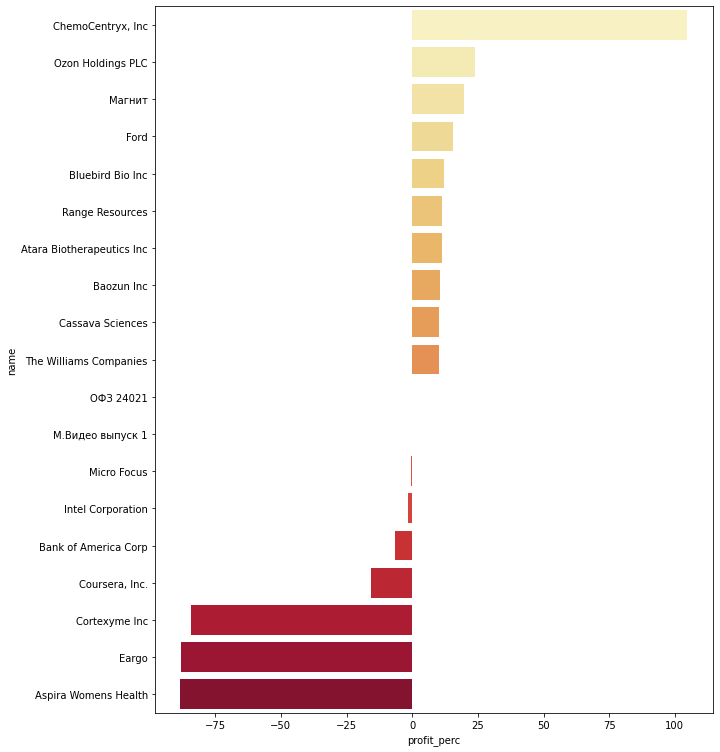

In [208]:
top = 10
for_graph_percent = df_closed[df_closed['profit_perc'] > 0].sort_values('profit_perc', ascending=False).head(top)\
                .append(df_closed[df_closed['profit_perc'] < 0].sort_values('profit_perc').head(top)).reset_index(drop=True)
for_graph_percent.sort_values('profit_perc', 
                      ascending=False, 
                      inplace=True)

plt.figure(figsize=(10, 13))
sns.barplot(y=for_graph_percent['name'], x=for_graph_percent['profit_perc'], palette="YlOrRd")

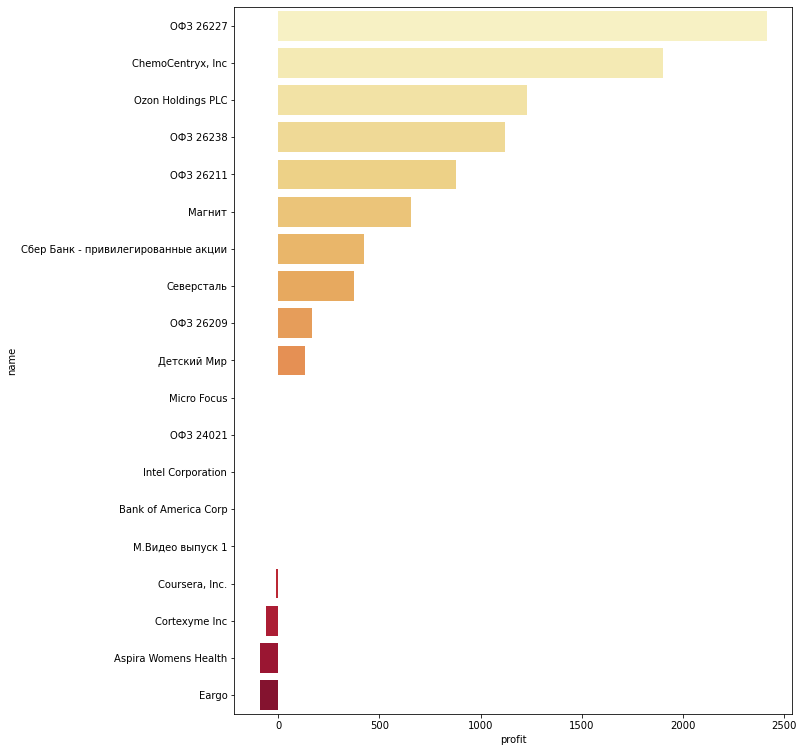

In [209]:
top = 10
for_graph_profit = df_closed[df_closed['profit'] > 0].sort_values('profit', ascending=False).head(top)\
                .append(df_closed[df_closed['profit'] < 0].sort_values('profit').head(top)).reset_index(drop=True)
for_graph_profit.sort_values('profit', 
                      ascending=False, 
                      inplace=True)

plt.figure(figsize=(10, 13))
sns.barplot(y=for_graph_profit['name'], x=for_graph_profit['profit'], palette="YlOrRd")

In [21]:
un_type = []


with Client(token) as client:
    r = client.operations.get_operations(account_id=account_id,
                                         from_=start_date,
                                         to=datetime.datetime.now()
                                        )
    for operation in r.operations:
        if operation.type not in un_type:
            un_type.append(operation.type)
un_type 

['Удержание комиссии за операцию',
 'Покупка ценных бумаг',
 'Продажа ценных бумаг',
 'Удержание комиссии за обслуживание брокерского счёта',
 'Выплата дивидендов',
 'Удержание налога по дивидендам',
 'Выплата купонов',
 'Удержание НДФЛ по купонам',
 'Списание вариационной маржи',
 'Вывод денежных средств',
 'Удержание налога',
 'Пополнение брокерского счёта',
 'Корректировка налога']

In [29]:
un_type = []


with Client(token) as client:
    r = client.operations.get_operations(account_id='2059303392',
                                         from_=datetime.datetime(2021,1,8),
                                         to=datetime.datetime.now()
                                        )
    for operation in r.operations:
        if operation.type == 'Удержание комиссии за операцию' :
            #print(operation.parent_operation_id)
            print(operation.type)
        print(operation.type, '|', operation.instrument_type,'|', operation.figi,'|', operation.parent_operation_id,'|',operation.date,'|',  operation.payment,'|', operation.price,'|', operation.state,'|', operation.quantity,'|', operation.type)
    #print(r)

Удержание комиссии за операцию
Удержание комиссии за операцию | currency | BBG0013HGFT4 | 23566923715 | 2022-06-03 12:53:26+00:00 | MoneyValue(currency='rub', units=-1, nano=-240000000) | MoneyValue(currency='rub', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Покупка ценных бумаг | currency | BBG0013HGFT4 |  | 2022-06-03 12:53:25+00:00 | MoneyValue(currency='rub', units=-309, nano=-210000000) | MoneyValue(currency='rub', units=61, nano=842000000) | OperationState.OPERATION_STATE_EXECUTED | 5 | Покупка ценных бумаг
Удержание комиссии за операцию
Удержание комиссии за операцию | bond | BBG011PCH913 | 31516318286 | 2022-06-03 12:53:01.058152+00:00 | MoneyValue(currency='rub', units=0, nano=-760000000) | MoneyValue(currency='rub', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Продажа ценных бумаг | bond | BBG011PCH913 |  | 2022-06-03 12:53:00.058152+00:00 | MoneyValue(currency='rub', units=

Вывод денежных средств |  |  |  | 2022-03-24 16:06:45+00:00 | MoneyValue(currency='rub', units=-11279, nano=-230000000) | MoneyValue(currency='rub', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Вывод денежных средств
Покупка ценных бумаг | currency | BBG0013HQ5K4 |  | 2022-03-24 15:51:59+00:00 | MoneyValue(currency='rub', units=-53007, nano=-500000000) | MoneyValue(currency='rub', units=106, nano=15000000) | OperationState.OPERATION_STATE_EXECUTED | 500 | Покупка ценных бумаг
Удержание комиссии за операцию
Удержание комиссии за операцию | currency | BBG0013HQ5K4 | 23112529660 | 2022-03-24 15:52:00+00:00 | MoneyValue(currency='rub', units=-21, nano=-200000000) | MoneyValue(currency='rub', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Удержание налога |  |  |  | 2022-03-24 15:43:54+00:00 | MoneyValue(currency='rub', units=-1694, nano=0) | MoneyValue(currency='rub', units=0, nano=0) | OperationState.OPERATION_STATE_EXEC

Продажа ценных бумаг | share | BBG00KHGQ0H4 |  | 2022-02-16 14:04:47.837000+00:00 | MoneyValue(currency='usd', units=46, nano=150000000) | MoneyValue(currency='usd', units=46, nano=150000000) | OperationState.OPERATION_STATE_EXECUTED | 1 | Продажа ценных бумаг
Удержание комиссии за операцию
Удержание комиссии за операцию | share | BBG00KHGQ0H4 | 39548102 | 2022-02-16 14:04:48.837000+00:00 | MoneyValue(currency='usd', units=0, nano=-20000000) | MoneyValue(currency='usd', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Покупка ценных бумаг | share | BBG005DXJS36 |  | 2022-02-16 10:49:34.898000+00:00 | MoneyValue(currency='usd', units=-144, nano=-360000000) | MoneyValue(currency='usd', units=72, nano=180000000) | OperationState.OPERATION_STATE_EXECUTED | 2 | Покупка ценных бумаг
Продажа ценных бумаг | share | BBG000BBQCY0 |  | 2022-02-16 10:46:45.153000+00:00 | MoneyValue(currency='usd', units=120, nano=330000000) | MoneyValue(currency='usd'

Удержание комиссии за операцию | share | BBG000BF6LY3 | 30657925 | 2021-12-23 14:21:22.940000+00:00 | MoneyValue(currency='usd', units=0, nano=-90000000) | MoneyValue(currency='usd', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Выплата дивидендов | share | BBG00475K6C3 |  | 2021-12-23 03:00:00+00:00 | MoneyValue(currency='rub', units=429, nano=650000000) | MoneyValue(currency='rub', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Выплата дивидендов
Удержание налога по дивидендам | share | BBG00475K6C3 |  | 2021-12-23 03:00:00+00:00 | MoneyValue(currency='rub', units=-56, nano=0) | MoneyValue(currency='rub', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание налога по дивидендам
Покупка ценных бумаг | share | BBG000BM2FL9 |  | 2021-12-22 07:20:30.812000+00:00 | MoneyValue(currency='usd', units=-41, nano=-300000000) | MoneyValue(currency='usd', units=8, nano=260000000) | OperationState.OPERATION_S

Удержание комиссии за операцию | share | BBG0016XJ8S0 | 323887733960 | 2021-11-01 13:52:54.574000+00:00 | MoneyValue(currency='usd', units=0, nano=-40000000) | MoneyValue(currency='usd', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Продажа ценных бумаг | share | BBG000PTSB12 |  | 2021-11-01 11:40:06.219000+00:00 | MoneyValue(currency='usd', units=0, nano=0) | MoneyValue(currency='usd', units=37, nano=0) | OperationState.OPERATION_STATE_CANCELED | 2 | Продажа ценных бумаг
Удержание комиссии за обслуживание брокерского счёта |  |  |  | 2021-11-01 11:37:54+00:00 | MoneyValue(currency='usd', units=-4, nano=-110000000) | MoneyValue(currency='usd', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за обслуживание брокерского счёта
Продажа ценных бумаг | share | BBG000P7S7L7 |  | 2021-11-01 11:12:41.844000+00:00 | MoneyValue(currency='usd', units=14, nano=800000000) | MoneyValue(currency='usd', units=7, nano=

Продажа ценных бумаг | share | BBG000BH5LT6 |  | 2021-09-28 13:42:19.834000+00:00 | MoneyValue(currency='usd', units=0, nano=0) | MoneyValue(currency='usd', units=4, nano=160000000) | OperationState.OPERATION_STATE_CANCELED | 10 | Продажа ценных бумаг
Продажа ценных бумаг | share | BBG000BH5LT6 |  | 2021-09-28 04:02:56.467000+00:00 | MoneyValue(currency='usd', units=0, nano=0) | MoneyValue(currency='usd', units=4, nano=170000000) | OperationState.OPERATION_STATE_CANCELED | 10 | Продажа ценных бумаг
Покупка ценных бумаг | share | BBG004KB3S72 |  | 2021-09-27 20:36:23.774000+00:00 | MoneyValue(currency='usd', units=-37, nano=-140000000) | MoneyValue(currency='usd', units=12, nano=380000000) | OperationState.OPERATION_STATE_EXECUTED | 3 | Покупка ценных бумаг
Удержание комиссии за операцию
Удержание комиссии за операцию | share | BBG004KB3S72 | 307975474680 | 2021-09-27 20:36:24.774000+00:00 | MoneyValue(currency='usd', units=0, nano=-110000000) | MoneyValue(currency='usd', units=0, nano=

Продажа ценных бумаг | share | BBG0047315Y7 |  | 2021-08-10 08:19:13.150000+00:00 | MoneyValue(currency='rub', units=6086, nano=200000000) | MoneyValue(currency='rub', units=304, nano=310000000) | OperationState.OPERATION_STATE_EXECUTED | 20 | Продажа ценных бумаг
Удержание комиссии за операцию
Удержание комиссии за операцию | share | BBG0047315Y7 | 25257311138 | 2021-08-10 08:19:14.150000+00:00 | MoneyValue(currency='rub', units=-18, nano=-260000000) | MoneyValue(currency='rub', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Продажа ценных бумаг | share | BBG0320C1036 |  | 2021-08-09 15:55:16.182000+00:00 | MoneyValue(currency='usd', units=106, nano=300000000) | MoneyValue(currency='usd', units=10, nano=630000000) | OperationState.OPERATION_STATE_EXECUTED | 10 | Продажа ценных бумаг
Удержание комиссии за операцию
Удержание комиссии за операцию | share | BBG0320C1036 | 284790915100 | 2021-08-09 15:55:17.182000+00:00 | MoneyValue(currency

Покупка ценных бумаг | share | BBG000PTSB12 |  | 2021-07-13 13:16:28.789000+00:00 | MoneyValue(currency='usd', units=0, nano=0) | MoneyValue(currency='usd', units=16, nano=500000000) | OperationState.OPERATION_STATE_CANCELED | 5 | Покупка ценных бумаг
Покупка ценных бумаг | share | BBG000P7S7L7 |  | 2021-07-13 09:24:30.624000+00:00 | MoneyValue(currency='usd', units=-73, nano=-150000000) | MoneyValue(currency='usd', units=6, nano=650000000) | OperationState.OPERATION_STATE_EXECUTED | 11 | Покупка ценных бумаг
Удержание комиссии за операцию
Удержание комиссии за операцию | share | BBG000P7S7L7 | 272097053550 | 2021-07-13 09:24:31.624000+00:00 | MoneyValue(currency='usd', units=0, nano=-220000000) | MoneyValue(currency='usd', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Покупка ценных бумаг | share | BBG000PTSB12 |  | 2021-07-12 14:13:08.119000+00:00 | MoneyValue(currency='usd', units=0, nano=0) | MoneyValue(currency='usd', units=16, nan

Удержание комиссии за операцию | share | BBG000KGYRF8 | 259040072990 | 2021-06-10 13:24:56.509000+00:00 | MoneyValue(currency='usd', units=0, nano=-40000000) | MoneyValue(currency='usd', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Продажа ценных бумаг | share | BBG000BCWG90 |  | 2021-06-10 13:24:40.058000+00:00 | MoneyValue(currency='usd', units=11, nano=650000000) | MoneyValue(currency='usd', units=11, nano=650000000) | OperationState.OPERATION_STATE_EXECUTED | 1 | Продажа ценных бумаг
Удержание комиссии за операцию
Удержание комиссии за операцию | share | BBG000BCWG90 | 259040029990 | 2021-06-10 13:24:40.058000+00:00 | MoneyValue(currency='usd', units=0, nano=-30000000) | MoneyValue(currency='usd', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Покупка ценных бумаг | share | BBG000B9ZLB0 |  | 2021-06-09 21:58:51.686000+00:00 | MoneyValue(currency='usd', units=-7, nano=-810000000) | Mo

Удержание комиссии за операцию | share | BBG00W0KZD98 | 243955424940 | 2021-05-10 20:49:17.692000+00:00 | MoneyValue(currency='usd', units=0, nano=-50000000) | MoneyValue(currency='usd', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Покупка ценных бумаг | share | BBG000BWVCP8 |  | 2021-05-10 20:38:54.475000+00:00 | MoneyValue(currency='usd', units=-25, nano=-650000000) | MoneyValue(currency='usd', units=25, nano=650000000) | OperationState.OPERATION_STATE_EXECUTED | 1 | Покупка ценных бумаг
Удержание комиссии за операцию
Удержание комиссии за операцию | share | BBG000BWVCP8 | 243954734250 | 2021-05-10 20:38:54.475000+00:00 | MoneyValue(currency='usd', units=0, nano=-80000000) | MoneyValue(currency='usd', units=0, nano=0) | OperationState.OPERATION_STATE_EXECUTED | 0 | Удержание комиссии за операцию
Продажа ценных бумаг | share | BBG002WLDMW5 |  | 2021-05-10 20:15:51.138000+00:00 | MoneyValue(currency='usd', units=34, nano=500000000) | M